Код выполняет полную pipeline-автоматизацию:

    загрузка видео,

    выделение аудио,

    анализ аудио и видео для определения сцен,

    интеллектуальное объединение сцен на основе аудио и видео весов,

    трекинг объектов в видео,

    распознавание речи и получение субтитров,

    финальная сегментация сцен с богатыми метаданными (объекты, текст),

    визуализация сценообразования,

    сохранение сцен отдельными видеофайлами,

    создание подробного отчёта по сценам.


In [1]:
!pip install -q torch torchvision torchaudio
!pip install -q opencv-python pytube moviepy pydub scenedetect[opencv] transformers
!pip install -q ultralytics
!pip install -q git+https://github.com/facebookresearch/detectron2.git
!pip install -q librosa pandas matplotlib seaborn
!pip install -q speechrecognition

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.6/131.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict
from datetime import timedelta

# Видео обработка
from pytube import YouTube
from moviepy.editor import VideoFileClip
import scenedetect
from scenedetect.detectors import ContentDetector
from scenedetect.scene_manager import SceneManager

# Аудио обработка
import librosa
import librosa.display
from pydub import AudioSegment
import speech_recognition as sr

# Обработка субтитров
from transformers import pipeline

# Детекция и трекинг объектов
from ultralytics import YOLO
import torch

ModuleNotFoundError: No module named 'pytube'

In [5]:
def download_youtube_video(url, output_path='./video.mp4'):
    yt = YouTube(url)
    stream = yt.streams.filter(file_extension='mp4', progressive=True).order_by('resolution').desc().first()
    stream.download(output_path=os.path.dirname(output_path), filename=os.path.basename(output_path))
    return output_path

# Пример использования (раскомментируйте для загрузки своего видео)
# video_path = download_youtube_video('https://www.youtube.com/watch?v=...')
# Или используйте свое видео
video_path = '30 секунд (2023)_1080p.mp4'

Функция для извлечения аудио из видео

In [6]:
def extract_audio(video_path, audio_path='audio.wav'):
    video = VideoFileClip(video_path)
    audio = video.audio
    audio.write_audiofile(audio_path, codec='pcm_s16le')
    return audio_path

audio_path = extract_audio(video_path)

MoviePy - Writing audio in audio.wav


MoviePy - Done.


Анализ аудио для обнаружения сцен

Вычисляет аудиохарактеристики по окнам:

    Нормализованная энергия RMS (Root Mean Square).

    Нормализованный спектральный центроид (характеристика частотного распределения).

    Zero Crossing Rate — количество пересечений аудиоволны с нулём (важно для различения тонов и шума).



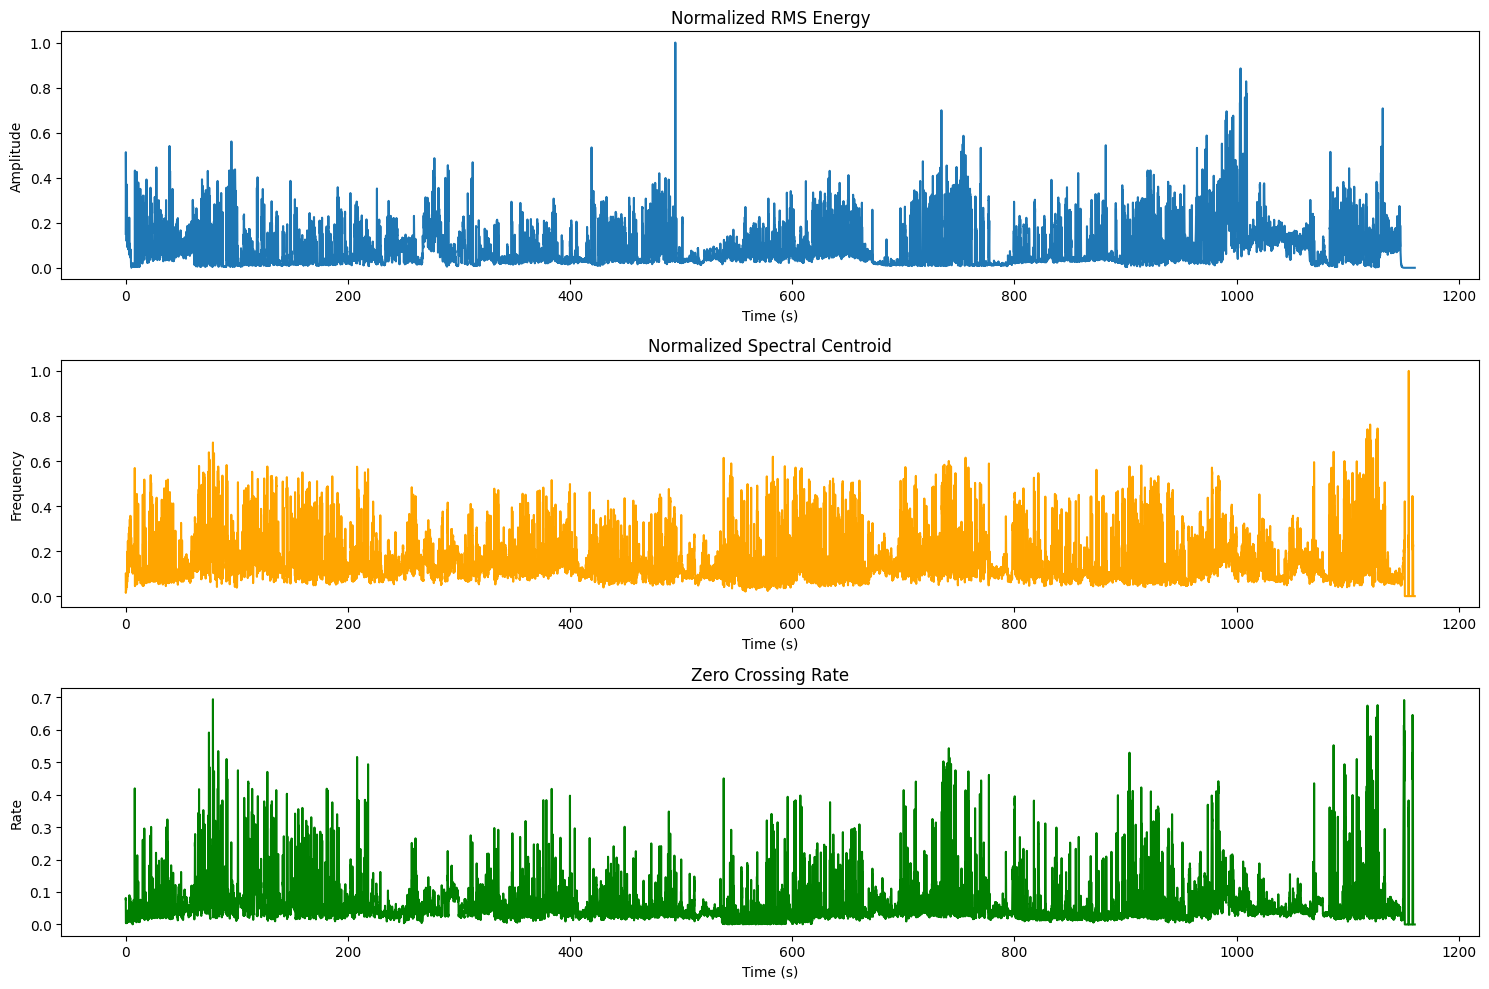

In [7]:
def analyze_audio(audio_path, frame_length=2048, hop_length=512):
    # Загрузка аудио
    y, sr = librosa.load(audio_path)

    # Вычисление RMS энергии
    rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]

    # Нормализация
    rms_normalized = (rms - np.min(rms)) / (np.max(rms) - np.min(rms))

    # Вычисление спектрального центроида
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=frame_length, hop_length=hop_length)[0]
    spectral_centroid_normalized = (spectral_centroid - np.min(spectral_centroid)) / (np.max(spectral_centroid) - np.min(spectral_centroid))

    # Вычисление zero crossing rate
    zcr = librosa.feature.zero_crossing_rate(y, frame_length=frame_length, hop_length=hop_length)[0]

    # Временная ось в секундах
    times = librosa.times_like(rms, sr=sr, hop_length=hop_length, n_fft=frame_length)

    return {
        'times': times,
        'rms': rms_normalized,
        'spectral_centroid': spectral_centroid_normalized,
        'zcr': zcr
    }

audio_features = analyze_audio(audio_path)

# Визуализация аудио признаков
def plot_audio_features(audio_features):
    plt.figure(figsize=(15, 10))

    plt.subplot(3, 1, 1)
    plt.plot(audio_features['times'], audio_features['rms'], label='RMS Energy')
    plt.title('Normalized RMS Energy')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    plt.subplot(3, 1, 2)
    plt.plot(audio_features['times'], audio_features['spectral_centroid'], label='Spectral Centroid', color='orange')
    plt.title('Normalized Spectral Centroid')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency')

    plt.subplot(3, 1, 3)
    plt.plot(audio_features['times'], audio_features['zcr'], label='Zero Crossing Rate', color='green')
    plt.title('Zero Crossing Rate')
    plt.xlabel('Time (s)')
    plt.ylabel('Rate')

    plt.tight_layout()
    plt.show()

plot_audio_features(audio_features)

Обнаружение сцен на основе видео контента

In [8]:
def detect_video_scenes(video_path, threshold=30.0):
    # Создаем менеджер сцен и детектор
    video = scenedetect.VideoManager([video_path])
    scene_manager = SceneManager()
    scene_manager.add_detector(ContentDetector(threshold=threshold))

    # Обрабатываем видео
    video.set_downscale_factor()
    video.start()
    scene_manager.detect_scenes(frame_source=video)

    # Получаем список сцен
    scene_list = scene_manager.get_scene_list()

    # Конвертируем в секунды
    scenes = []
    for scene in scene_list:
        start_time = scene[0].get_seconds()
        end_time = scene[1].get_seconds()
        scenes.append((start_time, end_time))

    return scenes

video_scenes = detect_video_scenes(video_path)
print(f"Обнаружено {len(video_scenes)} сцен на основе видео контента:")
for i, (start, end) in enumerate(video_scenes):
    print(f"Сцена {i+1}: {start:.2f} - {end:.2f} сек")

ERROR:pyscenedetect:VideoManager is deprecated and will be removed.
INFO:pyscenedetect:Loaded 1 video, framerate: 24.000 FPS, resolution: 1920 x 1080
INFO:pyscenedetect:Detecting scenes...


Обнаружено 196 сцен на основе видео контента:
Сцена 1: 0.00 - 12.62 сек
Сцена 2: 12.62 - 16.75 сек
Сцена 3: 16.75 - 20.79 сек
Сцена 4: 20.79 - 26.92 сек
Сцена 5: 26.92 - 31.08 сек
Сцена 6: 31.08 - 40.12 сек
Сцена 7: 40.12 - 43.67 сек
Сцена 8: 43.67 - 50.33 сек
Сцена 9: 50.33 - 52.29 сек
Сцена 10: 52.29 - 55.71 сек
Сцена 11: 55.71 - 59.21 сек
Сцена 12: 59.21 - 60.38 сек
Сцена 13: 60.38 - 63.29 сек
Сцена 14: 63.29 - 64.62 сек
Сцена 15: 64.62 - 72.00 сек
Сцена 16: 72.00 - 73.21 сек
Сцена 17: 73.21 - 76.54 сек
Сцена 18: 76.54 - 79.25 сек
Сцена 19: 79.25 - 81.88 сек
Сцена 20: 81.88 - 83.54 сек
Сцена 21: 83.54 - 85.42 сек
Сцена 22: 85.42 - 87.17 сек
Сцена 23: 87.17 - 91.29 сек
Сцена 24: 91.29 - 103.38 сек
Сцена 25: 103.38 - 111.79 сек
Сцена 26: 111.79 - 117.88 сек
Сцена 27: 117.88 - 121.00 сек
Сцена 28: 121.00 - 133.92 сек
Сцена 29: 133.92 - 139.75 сек
Сцена 30: 139.75 - 146.33 сек
Сцена 31: 146.33 - 168.83 сек
Сцена 32: 168.83 - 176.71 сек
Сцена 33: 176.71 - 180.12 сек
Сцена 34: 180.12 - 19

Обнаружение сцен на основе аудио

In [9]:
def detect_audio_scenes(audio_features, rms_threshold=0.3, centroid_threshold=0.4, min_scene_duration=3.0):
    times = audio_features['times']
    rms = audio_features['rms']
    spectral_centroid = audio_features['spectral_centroid']

    scenes = []
    current_scene_start = 0.0

    for i in range(1, len(times)):
        # Проверяем изменения в RMS и спектральном центроиде
        rms_change = abs(rms[i] - rms[i-1])
        centroid_change = abs(spectral_centroid[i] - spectral_centroid[i-1])

        # Если изменения значительные, считаем это границей сцены
        if rms_change > rms_threshold or centroid_change > centroid_threshold:
            scene_duration = times[i] - current_scene_start
            if scene_duration >= min_scene_duration:
                scenes.append((current_scene_start, times[i]))
                current_scene_start = times[i]

    # Добавляем последнюю сцену
    if current_scene_start < times[-1]:
        scenes.append((current_scene_start, times[-1]))

    return scenes

audio_scenes = detect_audio_scenes(audio_features)
print(f"\nОбнаружено {len(audio_scenes)} сцен на основе аудио анализа:")
for i, (start, end) in enumerate(audio_scenes):
    print(f"Сцена {i+1}: {start:.2f} - {end:.2f} сек")


Обнаружено 7 сцен на основе аудио анализа:
Сцена 1: 0.00 - 95.11 сек
Сцена 2: 95.11 - 494.72 сек
Сцена 3: 494.72 - 1126.70 сек
Сцена 4: 1126.70 - 1151.45 сек
Сцена 5: 1151.45 - 1155.01 сек
Сцена 6: 1155.01 - 1158.33 сек
Сцена 7: 1158.33 - 1160.42 сек


Объединение видео и аудио сцен

Для диалоговых сцен:


merge_scenes(video_scenes, audio_scenes,
            video_weight=0.4,  # меньше вес видео (частые смены кадров)
            audio_weight=0.6,  # больше вес аудио (диалог продолжается)
            max_scene_duration=90.0)
Для экшен-сцен:


merge_scenes(video_scenes, audio_scenes,
            video_weight=0.8,  # больше вес видео (важны визуальные изменения)
            audio_weight=0.2,
            max_scene_duration=30.0)
Балансный вариант:


merge_scenes(video_scenes, audio_scenes,
            video_weight=0.6,
            audio_weight=0.4,
            max_scene_duration=60.0)

            
Объединяет сцены с учётом весов, длительности, перекрытий и максимальной длительности.

Обнаружено 36 сцен после улучшенного объединения:
Сцена 1: 0.00 - 12.62 сек (длительность: 12.62 сек)
Сцена 2: 0.00 - 59.21 сек (длительность: 59.21 сек)
Сцена 3: 64.62 - 76.54 сек (длительность: 11.92 сек)
Сцена 4: 87.17 - 103.38 сек (длительность: 16.21 сек)
Сцена 5: 95.11 - 146.33 сек (длительность: 51.22 сек)
Сцена 6: 146.33 - 204.71 сек (длительность: 58.38 сек)
Сцена 7: 204.71 - 234.12 сек (длительность: 29.42 сек)
Сцена 8: 236.83 - 241.42 сек (длительность: 4.58 сек)
Сцена 9: 244.29 - 303.29 сек (длительность: 59.00 сек)
Сцена 10: 303.29 - 310.21 сек (длительность: 6.92 сек)
Сцена 11: 313.00 - 318.62 сек (длительность: 5.62 сек)
Сцена 12: 321.58 - 333.83 сек (длительность: 12.25 сек)
Сцена 13: 336.29 - 390.17 сек (длительность: 53.88 сек)
Сцена 14: 390.17 - 446.25 сек (длительность: 56.08 сек)
Сцена 15: 446.25 - 483.88 сек (длительность: 37.62 сек)
Сцена 16: 486.17 - 511.12 сек (длительность: 24.96 сек)
Сцена 17: 494.72 - 554.42 сек (длительность: 59.69 сек)
Сцена 18: 554.42 - 6

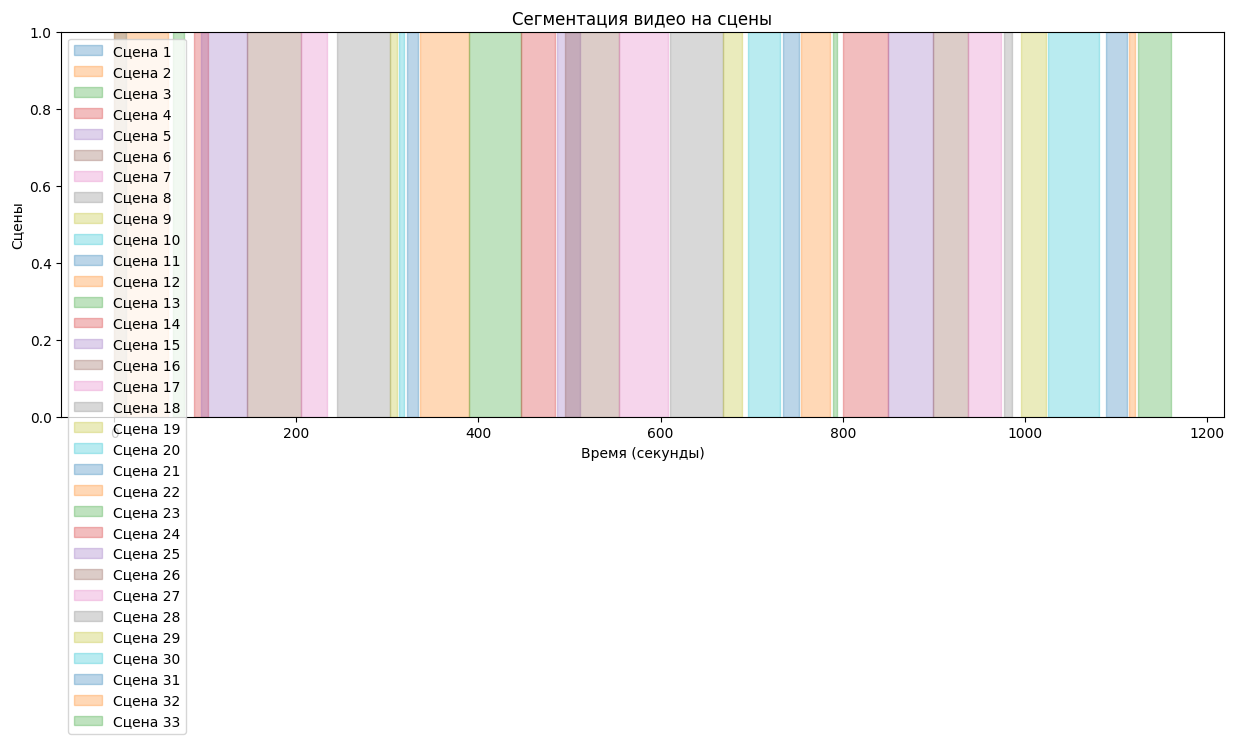

In [18]:
def merge_scenes(video_scenes, audio_scenes,
                video_weight=0.7, audio_weight=0.3,
                min_scene_duration=3.0, max_scene_duration=120.0,
                overlap_threshold=2.0):
    """
    Улучшенный алгоритм объединения сцен с учетом:
    - весовых коэффициентов для видео и аудио
    - минимальной и максимальной длительности сцен
    - сохранения логических границ
    """
    # Нормализуем и взвешиваем сцены
    weighted_scenes = []

    # Добавляем видео сцены с весом
    for start, end in video_scenes:
        duration = end - start
        if duration >= min_scene_duration:
            weighted_scenes.append({
                'start': start,
                'end': end,
                'weight': video_weight,
                'type': 'video'
            })

    # Добавляем аудио сцены с весом
    for start, end in audio_scenes:
        duration = end - start
        if duration >= min_scene_duration:
            weighted_scenes.append({
                'start': start,
                'end': end,
                'weight': audio_weight,
                'type': 'audio'
            })

    # Сортируем все сцены по времени начала
    weighted_scenes.sort(key=lambda x: x['start'])

    if not weighted_scenes:
        return []

    # Алгоритм интеллектуального объединения
    merged_scenes = []
    current_scene = weighted_scenes[0].copy()

    for scene in weighted_scenes[1:]:
        # Проверяем перекрытие или близость сцен
        scene_overlap = (scene['start'] <= current_scene['end'] + overlap_threshold)

        # Проверяем максимальную длительность
        duration_exceeded = (scene['end'] - current_scene['start']) > max_scene_duration

        # Если сцены пересекаются и не превышают максимальную длительность
        if scene_overlap and not duration_exceeded:
            # Объединяем сцены с учетом весов
            if scene['type'] == 'video' and current_scene['type'] != 'video':
                current_scene['end'] = scene['end']
                current_scene['weight'] += scene['weight']
                current_scene['type'] = 'mixed'
            elif scene['weight'] > current_scene['weight']:
                current_scene['end'] = scene['end']
                current_scene['weight'] += scene['weight']
                if scene['type'] != current_scene['type']:
                    current_scene['type'] = 'mixed'
            else:
                current_scene['end'] = max(current_scene['end'], scene['end'])
                current_scene['weight'] += scene['weight'] * 0.5  # меньший вес для расширения
        else:
            # Сохраняем текущую сцену и начинаем новую
            if current_scene['end'] - current_scene['start'] >= min_scene_duration:
                merged_scenes.append((current_scene['start'], current_scene['end']))
            current_scene = scene.copy()

    # Добавляем последнюю сцену
    if current_scene['end'] - current_scene['start'] >= min_scene_duration:
        merged_scenes.append((current_scene['start'], current_scene['end']))

    # Фильтруем слишком короткие сцены, которые могли появиться после объединения
    merged_scenes = [(start, end) for start, end in merged_scenes
                    if end - start >= min_scene_duration]

    return merged_scenes

# Параметры для нашего случая
video_weight = 0.7  # больший вес для видео сцен
audio_weight = 0.3  # меньший вес для аудио сцен
min_duration = 3.0  # минимальная длительность сцены в секундах
max_duration = 60.0 # максимальная длительность сцены в секундах

# Объединяем сцены с новыми параметрами
merged_scenes = merge_scenes(video_scenes, audio_scenes,
                           video_weight=video_weight,
                           audio_weight=audio_weight,
                           min_scene_duration=min_duration,
                           max_scene_duration=max_duration)

print(f"Обнаружено {len(merged_scenes)} сцен после улучшенного объединения:")
for i, (start, end) in enumerate(merged_scenes):
    print(f"Сцена {i+1}: {start:.2f} - {end:.2f} сек (длительность: {end-start:.2f} сек)")

# Финализируем сцены с трекингом объектов
final_scenes = final_scene_segmentation(merged_scenes, tracks_info)

# Визуализируем результат
visualize_scenes(final_scenes, video_path)

Динамическое определение весов (не опробовано):

In [ ]:
def calculate_dynamic_weights(video_scenes, audio_scenes):
    # Анализируем распределение длительностей
    avg_video_duration = np.mean([end-start for start,end in video_scenes])
    avg_audio_duration = np.mean([end-start for start,end in audio_scenes])

    # Чем больше средняя длительность, тем меньше вес
    video_weight = min(0.8, 0.2 + 0.6*(1 - avg_video_duration/120))
    audio_weight = min(0.8, 0.2 + 0.6*(1 - avg_audio_duration/300))

    return video_weight, audio_weight

v_weight, a_weight = calculate_dynamic_weights(video_scenes, audio_scenes)

Постобработка для объединения слишком коротких сцен:

In [ ]:
def postprocess_scenes(scenes, min_duration=5.0):
    if not scenes:
        return []

    processed = []
    current_start, current_end = scenes[0]

    for start, end in scenes[1:]:
        if start - current_end < min_duration*2:  # близкие сцены
            current_end = end
        else:
            if current_end - current_start >= min_duration:
                processed.append((current_start, current_end))
            current_start, current_end = start, end

    if current_end - current_start >= min_duration:
        processed.append((current_start, current_end))

    return processed

Трекинг объектов с помощью YOLOv8 и DeepSORT

In [12]:
# Загрузка модели YOLOv8
model = YOLO('yolov8l.pt')  # Используем большую модель для лучшей точности

# Функция для трекинга объектов в видео
def track_objects(video_path, output_path='output_tracked.mp4'):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Создаем VideoWriter для сохранения результата
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    # Словарь для хранения информации о треках
    tracks_info = defaultdict(list)

    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Выполняем трекинг с YOLOv8
        results = model.track(frame, persist=True, tracker="bytetrack.yaml")

        # Визуализация результатов
        annotated_frame = results[0].plot()

        # Сохраняем информацию о треках
        if results[0].boxes.id is not None:
            for box, track_id in zip(results[0].boxes, results[0].boxes.id):
                x1, y1, x2, y2 = box.xyxy[0].tolist()
                conf = box.conf[0].item()
                cls = box.cls[0].item()

                tracks_info[int(track_id)].append({
                    'frame': frame_count,
                    'time': frame_count / fps,
                    'bbox': [x1, y1, x2, y2],
                    'confidence': conf,
                    'class': cls
                })

        # Записываем кадр
        out.write(annotated_frame)
        frame_count += 1

    cap.release()
    out.release()

    return tracks_info, output_path

# Запускаем трекинг (может занять много времени)
tracks_info, tracked_video_path = track_objects(video_path)

100%|██████████| 83.7M/83.7M [00:00<00:00, 151MB/s]


Streaming output truncated to the last 5000 lines.
0: 384x640 (no detections), 1322.7ms
Speed: 2.6ms preprocess, 1322.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 1304.1ms
Speed: 2.7ms preprocess, 1304.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 1609.5ms
Speed: 4.5ms preprocess, 1609.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 1268.7ms
Speed: 2.8ms preprocess, 1268.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 1264.9ms
Speed: 2.3ms preprocess, 1264.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 1345.8ms
Speed: 3.2ms preprocess, 1345.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 1315.2ms
Speed: 3.1ms preprocess, 1315.2ms inference, 0.6ms postprocess per image at shape (1, 3, 3

Анализ субтитров (если доступны)

In [19]:
def extract_subtitles(audio_path, language='en'):
    r = sr.Recognizer()
    audio_file = sr.AudioFile(audio_path)

    subtitles = []

    with audio_file as source:
        duration = audio_file.DURATION
        chunk_size = 10  # секунды

        for i in range(0, int(duration), chunk_size):
            try:
                audio = r.record(source, duration=chunk_size, offset=i)
                text = r.recognize_google(audio, language=language)
                subtitles.append({
                    'start': i,
                    'end': i + chunk_size,
                    'text': text
                })
            except Exception as e:
                print(f"Ошибка при обработке отрезка {i}-{i+chunk_size}: {e}")
                continue

    return subtitles

# Пример использования (раскомментируйте при необходимости)
subtitles = extract_subtitles(audio_path)
for sub in subtitles:
  print(f"{sub['start']:.1f}-{sub['end']:.1f}: {sub['text']}")

Ошибка при обработке отрезка 10-20: 
Ошибка при обработке отрезка 20-30: 
Ошибка при обработке отрезка 40-50: 
Ошибка при обработке отрезка 60-70: 
Ошибка при обработке отрезка 70-80: 
Ошибка при обработке отрезка 80-90: 
Ошибка при обработке отрезка 90-100: 
Ошибка при обработке отрезка 100-110: 
Ошибка при обработке отрезка 120-130: 
Ошибка при обработке отрезка 130-140: 
Ошибка при обработке отрезка 140-150: 
Ошибка при обработке отрезка 150-160: 
Ошибка при обработке отрезка 160-170: 
Ошибка при обработке отрезка 170-180: 
Ошибка при обработке отрезка 180-190: 
Ошибка при обработке отрезка 190-200: 
Ошибка при обработке отрезка 200-210: 
Ошибка при обработке отрезка 210-220: 
Ошибка при обработке отрезка 220-230: 
Ошибка при обработке отрезка 230-240: 
Ошибка при обработке отрезка 240-250: 
Ошибка при обработке отрезка 250-260: 
Ошибка при обработке отрезка 260-270: 
Ошибка при обработке отрезка 270-280: 
Ошибка при обработке отрезка 280-290: 
Ошибка при обработке отрезка 290-300: 

Объединение всех данных для финальной сегментации

In [20]:
def final_scene_segmentation(merged_scenes, tracks_info, subtitles=None, min_scene_duration=5.0):
    final_scenes = []

    for scene_start, scene_end in merged_scenes:
        # Проверяем продолжительность сцены
        if scene_end - scene_start < min_scene_duration:
            continue

        # Анализируем объекты в сцене
        scene_tracks = {}
        for track_id, track_data in tracks_info.items():
            # Фильтруем объекты, которые находятся в текущей сцене
            objects_in_scene = [obj for obj in track_data if scene_start <= obj['time'] <= scene_end]
            if objects_in_scene:
                scene_tracks[track_id] = objects_in_scene

        # Анализируем субтитры (если есть)
        scene_text = ""
        if subtitles:
            for sub in subtitles:
                if scene_start <= sub['start'] <= scene_end or scene_start <= sub['end'] <= scene_end:
                    scene_text += sub['text'] + " "

        # Добавляем сцену в финальный список
        final_scenes.append({
            'start': scene_start,
            'end': scene_end,
            'duration': scene_end - scene_start,
            'objects': scene_tracks,
            'text': scene_text.strip() if scene_text else None
        })

    return final_scenes

final_scenes = final_scene_segmentation(merged_scenes, tracks_info)  # , subtitles)

# Выводим информацию о финальных сценах
print("\nФинальная сегментация сцен:")
for i, scene in enumerate(final_scenes):
    print(f"\nСцена {i+1}:")
    print(f"Время: {scene['start']:.2f} - {scene['end']:.2f} сек (длительность: {scene['duration']:.2f} сек)")
    print(f"Количество уникальных объектов: {len(scene['objects'])}")
    if scene['text']:
        print(f"Текст: {scene['text'][:100]}...")


Финальная сегментация сцен:

Сцена 1:
Время: 0.00 - 12.62 сек (длительность: 12.62 сек)
Количество уникальных объектов: 4

Сцена 2:
Время: 0.00 - 59.21 сек (длительность: 59.21 сек)
Количество уникальных объектов: 99

Сцена 3:
Время: 64.62 - 76.54 сек (длительность: 11.92 сек)
Количество уникальных объектов: 22

Сцена 4:
Время: 87.17 - 103.38 сек (длительность: 16.21 сек)
Количество уникальных объектов: 17

Сцена 5:
Время: 95.11 - 146.33 сек (длительность: 51.22 сек)
Количество уникальных объектов: 104

Сцена 6:
Время: 146.33 - 204.71 сек (длительность: 58.38 сек)
Количество уникальных объектов: 115

Сцена 7:
Время: 204.71 - 234.12 сек (длительность: 29.42 сек)
Количество уникальных объектов: 80

Сцена 8:
Время: 244.29 - 303.29 сек (длительность: 59.00 сек)
Количество уникальных объектов: 107

Сцена 9:
Время: 303.29 - 310.21 сек (длительность: 6.92 сек)
Количество уникальных объектов: 10

Сцена 10:
Время: 313.00 - 318.62 сек (длительность: 5.62 сек)
Количество уникальных объектов: 3



Визуализация результатов

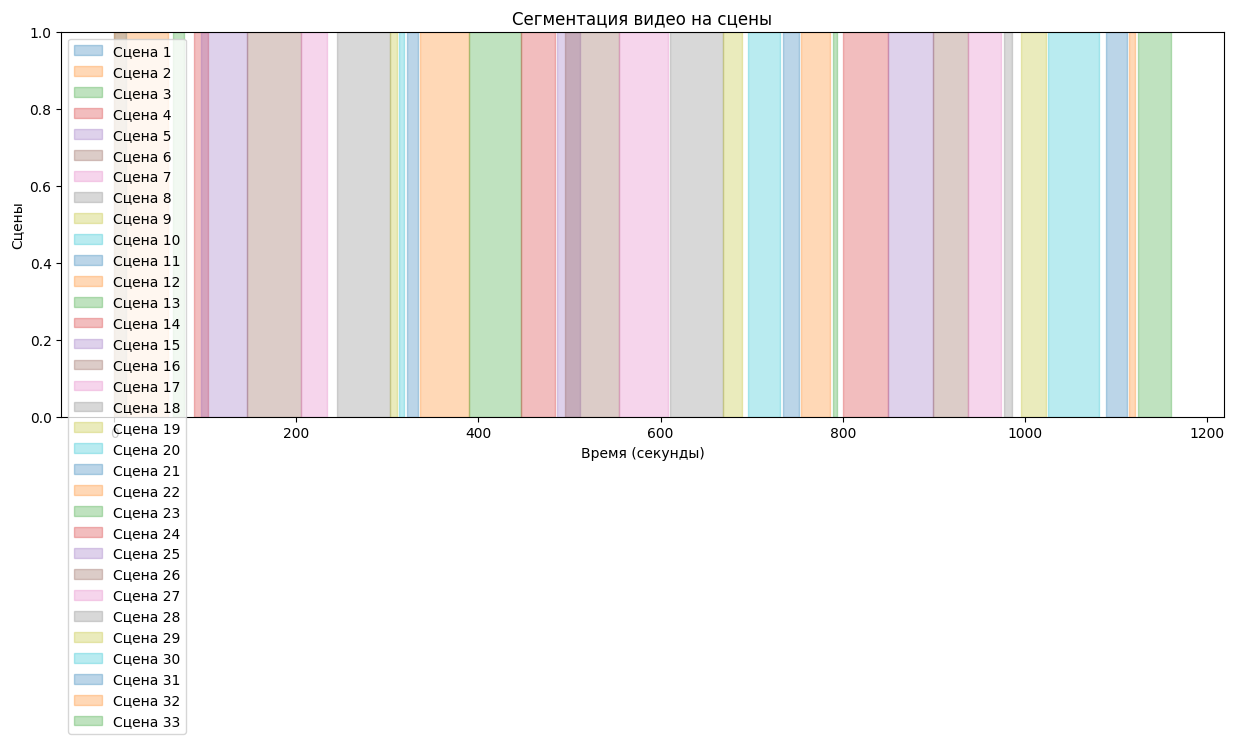

In [21]:
def visualize_scenes(final_scenes, video_path):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)

    plt.figure(figsize=(15, 5))

    # Создаем временную шкалу
    duration = cap.get(cv2.CAP_PROP_POS_MSEC) / 1000
    time_axis = np.linspace(0, duration, 100)

    # Визуализируем сцены
    for i, scene in enumerate(final_scenes):
        plt.axvspan(scene['start'], scene['end'], alpha=0.3, color=f'C{i}', label=f'Сцена {i+1}')

    plt.title('Сегментация видео на сцены')
    plt.xlabel('Время (секунды)')
    plt.ylabel('Сцены')
    plt.legend()
    plt.show()

    cap.release()

visualize_scenes(final_scenes, video_path)

Сохранение сцен как отдельных видеофайлов

In [22]:
def save_scenes_as_videos(video_path, final_scenes, output_dir='./scenes'):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    video_name = os.path.splitext(os.path.basename(video_path))[0]

    for i, scene in enumerate(final_scenes):
        output_path = os.path.join(output_dir, f"{video_name}_scene_{i+1}.mp4")

        # Используем moviepy для вырезания сцены
        clip = VideoFileClip(video_path).subclip(scene['start'], scene['end'])
        clip.write_videofile(output_path, codec='libx264', audio_codec='aac')

        print(f"Сохранена сцена {i+1} в {output_path}")

save_scenes_as_videos(video_path, final_scenes)

Moviepy - Building video ./scenes/30 секунд (2023)_1080p_scene_1.mp4.
MoviePy - Writing audio in 30 секунд (2023)_1080p_scene_1TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/30 секунд (2023)_1080p_scene_1.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/30 секунд (2023)_1080p_scene_1.mp4
Сохранена сцена 1 в ./scenes/30 секунд (2023)_1080p_scene_1.mp4
Moviepy - Building video ./scenes/30 секунд (2023)_1080p_scene_2.mp4.
MoviePy - Writing audio in 30 секунд (2023)_1080p_scene_2TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/30 секунд (2023)_1080p_scene_2.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/30 секунд (2023)_1080p_scene_2.mp4
Сохранена сцена 2 в ./scenes/30 секунд (2023)_1080p_scene_2.mp4
Moviepy - Building video ./scenes/30 секунд (2023)_1080p_scene_3.mp4.
MoviePy - Writing audio in 30 секунд (2023)_1080p_scene_3TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/30 секунд (2023)_1080p_scene_3.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/30 секунд (2023)_1080p_scene_3.mp4
Сохранена сцена 3 в ./scenes/30 секунд (2023)_1080p_scene_3.mp4
Moviepy - Building video ./scenes/30 секунд (2023)_1080p_scene_4.mp4.
MoviePy - Writing audio in 30 секунд (2023)_1080p_scene_4TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/30 секунд (2023)_1080p_scene_4.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/30 секунд (2023)_1080p_scene_4.mp4
Сохранена сцена 4 в ./scenes/30 секунд (2023)_1080p_scene_4.mp4
Moviepy - Building video ./scenes/30 секунд (2023)_1080p_scene_5.mp4.
MoviePy - Writing audio in 30 секунд (2023)_1080p_scene_5TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/30 секунд (2023)_1080p_scene_5.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/30 секунд (2023)_1080p_scene_5.mp4
Сохранена сцена 5 в ./scenes/30 секунд (2023)_1080p_scene_5.mp4
Moviepy - Building video ./scenes/30 секунд (2023)_1080p_scene_6.mp4.
MoviePy - Writing audio in 30 секунд (2023)_1080p_scene_6TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/30 секунд (2023)_1080p_scene_6.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/30 секунд (2023)_1080p_scene_6.mp4
Сохранена сцена 6 в ./scenes/30 секунд (2023)_1080p_scene_6.mp4
Moviepy - Building video ./scenes/30 секунд (2023)_1080p_scene_7.mp4.
MoviePy - Writing audio in 30 секунд (2023)_1080p_scene_7TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/30 секунд (2023)_1080p_scene_7.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/30 секунд (2023)_1080p_scene_7.mp4
Сохранена сцена 7 в ./scenes/30 секунд (2023)_1080p_scene_7.mp4
Moviepy - Building video ./scenes/30 секунд (2023)_1080p_scene_8.mp4.
MoviePy - Writing audio in 30 секунд (2023)_1080p_scene_8TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/30 секунд (2023)_1080p_scene_8.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/30 секунд (2023)_1080p_scene_8.mp4
Сохранена сцена 8 в ./scenes/30 секунд (2023)_1080p_scene_8.mp4
Moviepy - Building video ./scenes/30 секунд (2023)_1080p_scene_9.mp4.
MoviePy - Writing audio in 30 секунд (2023)_1080p_scene_9TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/30 секунд (2023)_1080p_scene_9.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/30 секунд (2023)_1080p_scene_9.mp4
Сохранена сцена 9 в ./scenes/30 секунд (2023)_1080p_scene_9.mp4
Moviepy - Building video ./scenes/30 секунд (2023)_1080p_scene_10.mp4.
MoviePy - Writing audio in 30 секунд (2023)_1080p_scene_10TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/30 секунд (2023)_1080p_scene_10.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/30 секунд (2023)_1080p_scene_10.mp4
Сохранена сцена 10 в ./scenes/30 секунд (2023)_1080p_scene_10.mp4
Moviepy - Building video ./scenes/30 секунд (2023)_1080p_scene_11.mp4.
MoviePy - Writing audio in 30 секунд (2023)_1080p_scene_11TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/30 секунд (2023)_1080p_scene_11.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/30 секунд (2023)_1080p_scene_11.mp4
Сохранена сцена 11 в ./scenes/30 секунд (2023)_1080p_scene_11.mp4
Moviepy - Building video ./scenes/30 секунд (2023)_1080p_scene_12.mp4.
MoviePy - Writing audio in 30 секунд (2023)_1080p_scene_12TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/30 секунд (2023)_1080p_scene_12.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/30 секунд (2023)_1080p_scene_12.mp4
Сохранена сцена 12 в ./scenes/30 секунд (2023)_1080p_scene_12.mp4
Moviepy - Building video ./scenes/30 секунд (2023)_1080p_scene_13.mp4.
MoviePy - Writing audio in 30 секунд (2023)_1080p_scene_13TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/30 секунд (2023)_1080p_scene_13.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/30 секунд (2023)_1080p_scene_13.mp4
Сохранена сцена 13 в ./scenes/30 секунд (2023)_1080p_scene_13.mp4
Moviepy - Building video ./scenes/30 секунд (2023)_1080p_scene_14.mp4.
MoviePy - Writing audio in 30 секунд (2023)_1080p_scene_14TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/30 секунд (2023)_1080p_scene_14.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/30 секунд (2023)_1080p_scene_14.mp4
Сохранена сцена 14 в ./scenes/30 секунд (2023)_1080p_scene_14.mp4
Moviepy - Building video ./scenes/30 секунд (2023)_1080p_scene_15.mp4.
MoviePy - Writing audio in 30 секунд (2023)_1080p_scene_15TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/30 секунд (2023)_1080p_scene_15.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/30 секунд (2023)_1080p_scene_15.mp4
Сохранена сцена 15 в ./scenes/30 секунд (2023)_1080p_scene_15.mp4
Moviepy - Building video ./scenes/30 секунд (2023)_1080p_scene_16.mp4.
MoviePy - Writing audio in 30 секунд (2023)_1080p_scene_16TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/30 секунд (2023)_1080p_scene_16.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/30 секунд (2023)_1080p_scene_16.mp4
Сохранена сцена 16 в ./scenes/30 секунд (2023)_1080p_scene_16.mp4
Moviepy - Building video ./scenes/30 секунд (2023)_1080p_scene_17.mp4.
MoviePy - Writing audio in 30 секунд (2023)_1080p_scene_17TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/30 секунд (2023)_1080p_scene_17.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/30 секунд (2023)_1080p_scene_17.mp4
Сохранена сцена 17 в ./scenes/30 секунд (2023)_1080p_scene_17.mp4
Moviepy - Building video ./scenes/30 секунд (2023)_1080p_scene_18.mp4.
MoviePy - Writing audio in 30 секунд (2023)_1080p_scene_18TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/30 секунд (2023)_1080p_scene_18.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/30 секунд (2023)_1080p_scene_18.mp4
Сохранена сцена 18 в ./scenes/30 секунд (2023)_1080p_scene_18.mp4
Moviepy - Building video ./scenes/30 секунд (2023)_1080p_scene_19.mp4.
MoviePy - Writing audio in 30 секунд (2023)_1080p_scene_19TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/30 секунд (2023)_1080p_scene_19.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/30 секунд (2023)_1080p_scene_19.mp4
Сохранена сцена 19 в ./scenes/30 секунд (2023)_1080p_scene_19.mp4
Moviepy - Building video ./scenes/30 секунд (2023)_1080p_scene_20.mp4.
MoviePy - Writing audio in 30 секунд (2023)_1080p_scene_20TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/30 секунд (2023)_1080p_scene_20.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/30 секунд (2023)_1080p_scene_20.mp4
Сохранена сцена 20 в ./scenes/30 секунд (2023)_1080p_scene_20.mp4
Moviepy - Building video ./scenes/30 секунд (2023)_1080p_scene_21.mp4.
MoviePy - Writing audio in 30 секунд (2023)_1080p_scene_21TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/30 секунд (2023)_1080p_scene_21.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/30 секунд (2023)_1080p_scene_21.mp4
Сохранена сцена 21 в ./scenes/30 секунд (2023)_1080p_scene_21.mp4
Moviepy - Building video ./scenes/30 секунд (2023)_1080p_scene_22.mp4.
MoviePy - Writing audio in 30 секунд (2023)_1080p_scene_22TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/30 секунд (2023)_1080p_scene_22.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/30 секунд (2023)_1080p_scene_22.mp4
Сохранена сцена 22 в ./scenes/30 секунд (2023)_1080p_scene_22.mp4
Moviepy - Building video ./scenes/30 секунд (2023)_1080p_scene_23.mp4.
MoviePy - Writing audio in 30 секунд (2023)_1080p_scene_23TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/30 секунд (2023)_1080p_scene_23.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/30 секунд (2023)_1080p_scene_23.mp4
Сохранена сцена 23 в ./scenes/30 секунд (2023)_1080p_scene_23.mp4
Moviepy - Building video ./scenes/30 секунд (2023)_1080p_scene_24.mp4.
MoviePy - Writing audio in 30 секунд (2023)_1080p_scene_24TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/30 секунд (2023)_1080p_scene_24.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/30 секунд (2023)_1080p_scene_24.mp4
Сохранена сцена 24 в ./scenes/30 секунд (2023)_1080p_scene_24.mp4
Moviepy - Building video ./scenes/30 секунд (2023)_1080p_scene_25.mp4.
MoviePy - Writing audio in 30 секунд (2023)_1080p_scene_25TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/30 секунд (2023)_1080p_scene_25.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/30 секунд (2023)_1080p_scene_25.mp4
Сохранена сцена 25 в ./scenes/30 секунд (2023)_1080p_scene_25.mp4
Moviepy - Building video ./scenes/30 секунд (2023)_1080p_scene_26.mp4.
MoviePy - Writing audio in 30 секунд (2023)_1080p_scene_26TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/30 секунд (2023)_1080p_scene_26.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/30 секунд (2023)_1080p_scene_26.mp4
Сохранена сцена 26 в ./scenes/30 секунд (2023)_1080p_scene_26.mp4
Moviepy - Building video ./scenes/30 секунд (2023)_1080p_scene_27.mp4.
MoviePy - Writing audio in 30 секунд (2023)_1080p_scene_27TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/30 секунд (2023)_1080p_scene_27.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/30 секунд (2023)_1080p_scene_27.mp4
Сохранена сцена 27 в ./scenes/30 секунд (2023)_1080p_scene_27.mp4
Moviepy - Building video ./scenes/30 секунд (2023)_1080p_scene_28.mp4.
MoviePy - Writing audio in 30 секунд (2023)_1080p_scene_28TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/30 секунд (2023)_1080p_scene_28.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/30 секунд (2023)_1080p_scene_28.mp4
Сохранена сцена 28 в ./scenes/30 секунд (2023)_1080p_scene_28.mp4
Moviepy - Building video ./scenes/30 секунд (2023)_1080p_scene_29.mp4.
MoviePy - Writing audio in 30 секунд (2023)_1080p_scene_29TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/30 секунд (2023)_1080p_scene_29.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/30 секунд (2023)_1080p_scene_29.mp4
Сохранена сцена 29 в ./scenes/30 секунд (2023)_1080p_scene_29.mp4
Moviepy - Building video ./scenes/30 секунд (2023)_1080p_scene_30.mp4.
MoviePy - Writing audio in 30 секунд (2023)_1080p_scene_30TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/30 секунд (2023)_1080p_scene_30.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/30 секунд (2023)_1080p_scene_30.mp4
Сохранена сцена 30 в ./scenes/30 секунд (2023)_1080p_scene_30.mp4
Moviepy - Building video ./scenes/30 секунд (2023)_1080p_scene_31.mp4.
MoviePy - Writing audio in 30 секунд (2023)_1080p_scene_31TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/30 секунд (2023)_1080p_scene_31.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/30 секунд (2023)_1080p_scene_31.mp4
Сохранена сцена 31 в ./scenes/30 секунд (2023)_1080p_scene_31.mp4
Moviepy - Building video ./scenes/30 секунд (2023)_1080p_scene_32.mp4.
MoviePy - Writing audio in 30 секунд (2023)_1080p_scene_32TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/30 секунд (2023)_1080p_scene_32.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/30 секунд (2023)_1080p_scene_32.mp4
Сохранена сцена 32 в ./scenes/30 секунд (2023)_1080p_scene_32.mp4
Moviepy - Building video ./scenes/30 секунд (2023)_1080p_scene_33.mp4.
MoviePy - Writing audio in 30 секунд (2023)_1080p_scene_33TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/30 секунд (2023)_1080p_scene_33.mp4



t:  99%|█████████▉| 867/872 [00:56<00:00, 35.96it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file 30 секунд (2023)_1080p.mp4, 6220800 bytes wanted but 0 bytes read,at frame 27849/27850, at time 1160.38/1160.38 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready ./scenes/30 секунд (2023)_1080p_scene_33.mp4
Сохранена сцена 33 в ./scenes/30 секунд (2023)_1080p_scene_33.mp4


Генерация отчета

In [23]:
def generate_report(final_scenes, output_path='report.csv'):
    report_data = []

    for i, scene in enumerate(final_scenes):
        # Основная информация о сцене
        scene_info = {
            'scene_number': i+1,
            'start_time': scene['start'],
            'end_time': scene['end'],
            'duration': scene['duration'],
            'num_objects': len(scene['objects']),
            'main_objects': ', '.join([f"ID {track_id}" for track_id in scene['objects']][:3]) + ('...' if len(scene['objects']) > 3 else '')
        }

        # Добавляем текст (если есть)
        if scene['text']:
            scene_info['text_sample'] = scene['text'][:100] + ('...' if len(scene['text']) > 100 else '')
        else:
            scene_info['text_sample'] = ''

        report_data.append(scene_info)

    # Создаем DataFrame и сохраняем в CSV
    df = pd.DataFrame(report_data)
    df.to_csv(output_path, index=False)
    print(f"Отчет сохранен в {output_path}")

    return df

report_df = generate_report(final_scenes)
display(report_df)

Отчет сохранен в report.csv


,scene_number,start_time,end_time,duration,num_objects,main_objects,text_sample
0,1,0.000000,12.625000,12.625000,4,"ID 1, ID 8, ID 9...",
1,2,0.000000,59.208333,59.208333,99,"ID 1, ID 8, ID 9...",
2,3,64.625000,76.541667,11.916667,22,"ID 489, ID 500, ID 507...",
3,4,87.166667,103.375000,16.208333,17,"ID 624, ID 648, ID 650...",
4,5,95.108934,146.333333,51.224399,104,"ID 624, ID 653, ID 671...",
5,6,146.333333,204.708333,58.375000,115,"ID 1024, ID 1067, ID 1070...",
6,7,204.708333,234.125000,29.416667,80,"ID 1344, ID 1448, ID 1525...",
7,8,244.291667,303.291667,59.000000,107,"ID 1869, ID 2023, ID 2031...",
8,9,303.291667,310.208333,6.916667,10,"ID 2418, ID 2471, ID 2483...",
9,10,313.000000,318.625000,5.625000,3,"ID 2418, ID 2538, ID 2544",
